# BADMINTON STROKE CLASSIFICATION
### AN END TO END MACHINE LEARNING PROJECT

This project is on classifying the type of badminton stroke player played using the data collected from a small wrist device. This device gives us accelorometer and gyroscope data and is attached to the player's wrist. This project was part of Data Analytics course we did at IISc. And it involved everything from data collection, cleaning up till the final ML model evaluation.

This jupyter notebook explains "what we did?" and "how we did it?" (the code).

## Defining the problem

To start off, we first need to define and properly formulate the problem we want to solve. Since, this was a course project we could have chosen any problem. We finalized to work on classifying the kind of stroke a player is playing based on the sensor's data we get from her smartwatch. This was an extension of Human Activity Recognition (HAR) project, which using similar data, classifies the activities as running, walking, etc. In our case,  we decided to have the following badminton strokes as classes:
* Backhand Overarm (bo)
* Backhand Underarm (bu)
* Forehand Overarm (fo)
* Forehand Underarm (fu)
* Forehand Smash (fs)

The 2 letter in parenthesis are abbreviations of the strokes, which we'll be using throughout this notebook.

## Data
As per our knowledge, there was no publicly available data for this problem. There have been some research papers, but we couldn't get our hands on the data. So we decided to collect it ourselves (Why not? Can give it a try).

### Setup for collecting data
We got hold on a device which can give us accelorometer and gyroscope readings over a period of time at a descent frequency. The device was powered by a small cell and connected via bluetooth low energy (BLE) to a rasperry pi. So we collected our data on rasperry pi in csv formats.

### Collecting data
Thanks to our 5 volunteers, we collected the data for the 5 mentioned strokes by making them repeatedly play the same shot. Although this might be very different than a real game, but we tried to make them play as they are playing a real game, (i.e. starting from center position, going towards the shuttle cock and returning back to resting position). The device had it's own limitation (coverage, power, etc) which made it challenging. Going through all of this we finally got our data.

## Visualizing the data

In [1]:
# Some imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks  #For finding peaks (we'll see later)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pickle

The data is saved in the data folder. We have 25 different csv files, for 5 players, 5 classes each. The naming convention is playerid_strokename. e.g. p2_bu.csv file contains data of player id 2 for "backhand underarm".

The columns in each file are: timestamp, accelorometer x-axis (ax), y-axis (ay), z-axis (az), gyroscope x-axis (gx), y-axis (gy), z-axis (gz). We also added magnitudes of accelerometer and gyroscope.

In [2]:
# Columns in data files
cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']  # Accelerometer and gyroscope in 3 axis
addedCols = ['acc_mag', 'gyro_mag']          # Magnitude of acc and gyro

In [3]:
# Data reading
data = {}
persons = ["p1", "p2", "p3", "p4", "p5"]
shots = ["bo", "bu", "fo", "fs", "fu"]
for person in persons:
    for shot in shots:
        data[person + "_" + shot] = pd.read_csv("data/" + str(person) + "_" + str(shot) + ".csv")
        data[person + "_" + shot]['acc_mag'] = np.linalg.norm(data[person + "_" + shot][cols[:3]].values,axis=1)
        data[person + "_" + shot]['gyro_mag'] = np.linalg.norm(data[person + "_" + shot][cols[3:]].values,axis=1)

Let's plot one of the csv, say p5_bo.

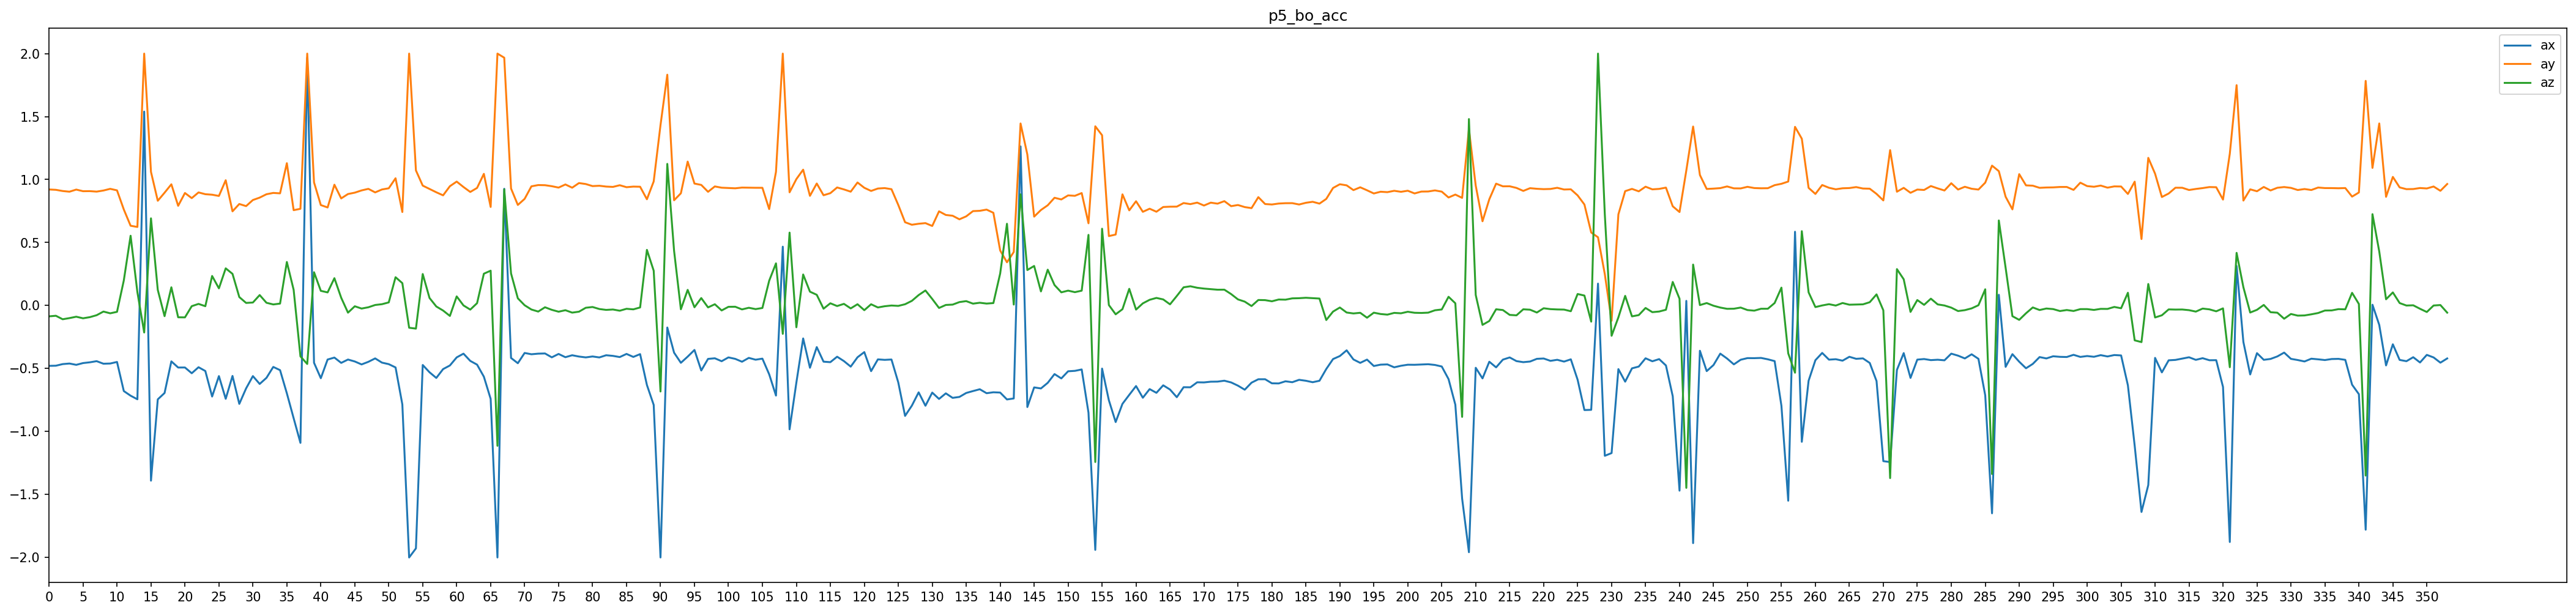

In [4]:
plotName = "p5_bo"

# Set figure width as per the number of readings
plt.figure(figsize=(len(data[plotName])/10, 8), dpi=150)

# Plot for each accelerometer column
for col in cols[0:3]:
    plt.plot(data[plotName][col], label=col)

plt.xlim(xmin=0)
plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
plt.title(plotName + "_acc")
plt.legend()
plt.show()

## Data cleaning

The peaks in the above plot are the shots, and in between we have some rest times. The shots are not at uniform intervals, sometimes the rest period is very long (as in between 160 and 200 in above plot). So we need to extract out shots from this continous plot and remove all these players' resting periods. 

The approach we took was to take a window around the peaks in the signal. Many design decisions were to be made, like, should the window by dynamic or fixed? If fixed, window size? peaks in which signal, accelorometer or gyroscope, x or y or z? one signal or many signals? how to consider some spike as peak? any thresholding? any noise reduction algorithm?

We did some EDA by plotting all the data and chose a window size of 13. This was our choice by our observations. And we chose the ay-signal to consider for extracting peaks and window, with different threshold values for each class of stroke.

In [5]:
# Size of the window, it is common for all shots
windowSize = 13
# shots = ["bo", "bu", "fo", "fs", "fu"] for reference
# Name of the sensor to be used for thresholding and the threshold value, the order is as per the shots list order
sensorToThreshold = ['ay', 'ay', 'ay', 'ay', 'ay']
threshold = [1.25, 1.25, 1.5, 1.5, 1.5]


In [6]:
# DATA PLOTTING - This will save all the plots in plots folder
for p_name in persons:
    for s_name in shots:
        s_index = shots.index(s_name)  # Shot index of that shot
        plotName = p_name + "_" + s_name
        
        # Set figure width as per the number of readings
        plt.figure(figsize=(len(data[plotName])/10, 5), dpi=100)
        
        # Plot peaks with threashold of that shot and give the name of sensor used for thresholding
        peaks, _ = find_peaks(data[plotName][sensorToThreshold[s_index]], height=threshold[s_index])
        #plt.plot(peaks, data[plotName][sensorToThreshold[s_index]][peaks], "x", c='red')
        
        # Plot for each accelerometer column
        for col in cols[0:3]:
            plt.plot(data[plotName][col], label=col)

        # drawing windows around each peak
        for peak in peaks:
            plt.axvspan(int(peak - windowSize/2), int(peak + windowSize/2), alpha =.1, facecolor='g',edgecolor='black')
        
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
        plt.title(plotName + "_acc")
        plt.legend()
        plt.savefig("plots/" + plotName + "_acc")
        #plt.show()
        plt.close();
        
        # Plot for each gyrometer column (not drawing peaks in these)
        
        # Set figure width as per the number of readings
        plt.figure(figsize=(len(data[plotName])/10, 5), dpi=100)
        
        for col in cols[3:]:
            plt.plot(data[plotName][col], label=col)

        # drawing windows around each peak
        for peak in peaks:
            plt.axvspan(int(peak - windowSize/2), int(peak + windowSize/2), alpha =.1, facecolor='g',edgecolor='black')
        
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
        plt.title(plotName + "_gyro")
        plt.legend()
        plt.savefig("plots/" + plotName + "_gyro")
        #plt.show()
        plt.close();
                  
        # Magnitude - Acc
        # Set figure width as per the number of readings
        plt.figure(figsize=(len(data[plotName])/10, 5), dpi=100)

        plt.plot(data[plotName][addedCols[0]], label="Magnitude Accelorometer")

        # drawing windows around each peak
        for peak in peaks:
            plt.axvspan(int(peak - windowSize/2), int(peak + windowSize/2), alpha =.1, facecolor='g',edgecolor='black')
        
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
        plt.title(plotName + "_mag_acc")
        plt.legend()
        plt.savefig("plots/" + plotName + "_mag_acc")
        #plt.show()
        plt.close();
        
        # Magnitude - Gyro
        # Set figure width as per the number of readings
        plt.figure(figsize=(len(data[plotName])/10, 5), dpi=100)

        plt.plot(data[plotName][addedCols[1]], label="Magnitude Gyroscope")

        # drawing windows around each peak
        for peak in peaks:
            plt.axvspan(int(peak - windowSize/2), int(peak + windowSize/2), alpha =.1, facecolor='g',edgecolor='black')
        
        plt.xlim(xmin=0)
        plt.xticks(np.arange(0, len(data[plotName])+1, 5.0))
        plt.title(plotName + "_mag_gyro")
        plt.legend()
        plt.savefig("plots/" + plotName + "_mag_gyro")
        #plt.show()
        plt.close();
        

Now this is what our extracted shots look like. 

Accelorometer:
<img src="plots/p5_bu_acc.png">

Gyroscope:
<img src="plots/p5_bu_gyro.png">

There are some overlaps, either because of shots being very close to each other or because of double peaks showing up in some shots. And some shots are missed because of low threshold value. But this is what we found to give reasonable balance between extracting good shots and not the noisy ones.

We'll save the start and end frame for each of these extracted shots in an X_y dataframe, along with the true labels. Later on, we'll augment this dataframe with hand engineered features. We are also saving person id although it's not used in classification.

In [7]:
# Final data frame with features described in doc along with shot name
X_y = pd.DataFrame(columns=['StartFrame', 'EndFrame', 'PersonID', 'ShotName'])

# Creating final data frame and adding end and begin frame of window
for p_name in persons:
    for s_name in shots:
        s_index = shots.index(s_name)  # Shot index of that shot
        plotName = p_name + "_" + s_name
        # Find peaks for window
        #TODO: we can look at peak_features(second returned value) for more data features
        timeSeries = data[plotName][sensorToThreshold[s_index]]
        peaks, _ = find_peaks(timeSeries, height=threshold[s_index])
        for peak in peaks:
            if(peak < windowSize/2 or peak > len(timeSeries)-windowSize/2):
                #print(peak)
                continue
            d = {'StartFrame': int(peak - windowSize/2),
                 'EndFrame': int(peak + windowSize/2), 
                 'PersonID': p_name, 
                 'ShotName': s_name}
            #print(d)
            X_y = X_y.append(d, ignore_index=True)
            

In [8]:
X_y

,StartFrame,EndFrame,PersonID,ShotName
0,4,17,p1,bo
1,7,20,p1,bo
2,22,35,p1,bo
3,60,73,p1,bo
4,75,88,p1,bo
5,77,90,p1,bo
6,94,107,p1,bo
7,143,156,p1,bo
8,162,175,p1,bo
9,179,192,p1,bo


We have extracted the shots out of the continous data we had. Total data: 708 (Not much, but let's see). Now let's see how much imbalance is there in our data. We'll handle that (if any). And then move on to adding features.

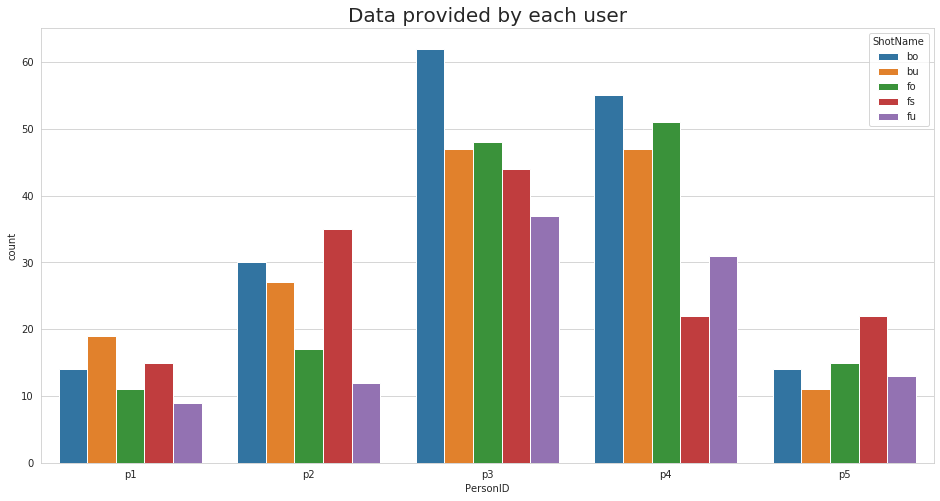

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='PersonID', hue='ShotName', data = X_y)
plt.savefig("plots/data_count")

plt.show()

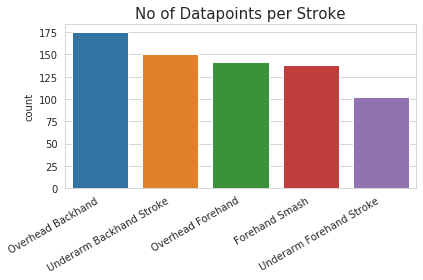

In [10]:
shotFullName = {
    'fo': "Overhead Forehand",
    'bo': "Overhead Backhand",
    'fs': "Forehand Smash",
    'fu': "Underarm Forehand Stroke",
    'bu': "Underarm Backhand Stroke",
}
plt.title('No of Datapoints per Stroke', fontsize=15)
sns.countplot([shotFullName[i] for i in X_y.ShotName]).set_xticklabels([shotFullName[i] for i in shots], 
                                                                       rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.savefig("plots/stroke_count")
plt.show()

There is a lot of difference in the amount of data we collected from each person (We didn't realized it during collection). But there isn't much imbalace between the classes (there is, but not much), so we'll work with this only.

## Adding Features for classical ML models

We will be using this X_y dataframe to store all our features for all the samples. And then use it for training classical machine learning models.

After some searching we found following features that we can add to such a time series data.
* Range
* Minimum
* Maximum
* Average
* Absolute Average
* Kurtosis f 
* Kurtosis p 
* Skewness statistic and p value
* Entropy
* Standard Deviation
* Angle betweenness
* Inter quartile range
* maxmin relative position ( Max position - min position , to see if max comes before min or vice-versa)

In [11]:
# List of features we'll add
features = []

In [12]:
# Some helper functions

# Add feature which depends only on one sensor, like range
def add_feature(fname, sensor):
    v = [fname(data[str(row['PersonID']) + "_" + str(row['ShotName'])][int(row['StartFrame']):int(row['EndFrame'])],
              sensor)
            for index, row in X_y.iterrows()]
    X_y[fname.__name__ + str(sensor)] = v
    if(fname.__name__ + str(sensor) not in features):
        features.append(fname.__name__ + str(sensor))
    print("Added feature " + fname.__name__ + str(sensor) + " for " + str(len(v)) + " rows.")
    
# Add feature which depends on more than one sensors, like magnitude
def add_feature_mult_sensor(fname, sensors):
    v = [fname(data[str(row['PersonID']) + "_" + str(row['ShotName'])][int(row['StartFrame']):int(row['EndFrame'])],
              sensors)
             for index, row in X_y.iterrows()]
    
    name = "_".join(sensors)
    X_y[fname.__name__ + name] = v
    if(fname.__name__ + name not in features):
        features.append(fname.__name__ + name)
    print("Added feature " + fname.__name__ + name + " for " + str(len(v)) + " rows.")

In [13]:
# Range 
def range_(df, sensor):
    return np.max(df[sensor]) - np.min(df[sensor])
for sensor in cols + addedCols:
    add_feature(range_, sensor)

Added feature range_ax for 708 rows.
Added feature range_ay for 708 rows.
Added feature range_az for 708 rows.
Added feature range_gx for 708 rows.
Added feature range_gy for 708 rows.
Added feature range_gz for 708 rows.
Added feature range_acc_mag for 708 rows.
Added feature range_gyro_mag for 708 rows.


In [14]:
# Minimum
def min_(df, sensor):
    return np.min(df[sensor])
for sensor in cols + addedCols:
    add_feature(min_, sensor)

Added feature min_ax for 708 rows.
Added feature min_ay for 708 rows.
Added feature min_az for 708 rows.
Added feature min_gx for 708 rows.
Added feature min_gy for 708 rows.
Added feature min_gz for 708 rows.
Added feature min_acc_mag for 708 rows.
Added feature min_gyro_mag for 708 rows.


In [15]:
# Maximum
def max_(df, sensor):
    return np.max(df[sensor])
for sensor in cols + addedCols:
    add_feature(max_, sensor)

Added feature max_ax for 708 rows.
Added feature max_ay for 708 rows.
Added feature max_az for 708 rows.
Added feature max_gx for 708 rows.
Added feature max_gy for 708 rows.
Added feature max_gz for 708 rows.
Added feature max_acc_mag for 708 rows.
Added feature max_gyro_mag for 708 rows.


In [16]:
# Average
def avg_(df, sensor):
    return np.mean(df[sensor])
for sensor in cols + addedCols:
    add_feature(avg_, sensor)

Added feature avg_ax for 708 rows.
Added feature avg_ay for 708 rows.
Added feature avg_az for 708 rows.
Added feature avg_gx for 708 rows.
Added feature avg_gy for 708 rows.
Added feature avg_gz for 708 rows.
Added feature avg_acc_mag for 708 rows.
Added feature avg_gyro_mag for 708 rows.


In [17]:
# Absolute Average
def absavg_(df, sensor):
    return np.mean(np.absolute(df[sensor]))
for sensor in cols + addedCols:
    add_feature(absavg_, sensor)

Added feature absavg_ax for 708 rows.
Added feature absavg_ay for 708 rows.
Added feature absavg_az for 708 rows.
Added feature absavg_gx for 708 rows.
Added feature absavg_gy for 708 rows.
Added feature absavg_gz for 708 rows.
Added feature absavg_acc_mag for 708 rows.
Added feature absavg_gyro_mag for 708 rows.


In [18]:
def kurtosis_f_(df , sensor):
    from scipy.stats import kurtosis 
    val = kurtosis(df[sensor],fisher = True)
    return val
for sensor in cols + addedCols:
    add_feature(kurtosis_f_, sensor)

Added feature kurtosis_f_ax for 708 rows.
Added feature kurtosis_f_ay for 708 rows.
Added feature kurtosis_f_az for 708 rows.
Added feature kurtosis_f_gx for 708 rows.
Added feature kurtosis_f_gy for 708 rows.
Added feature kurtosis_f_gz for 708 rows.
Added feature kurtosis_f_acc_mag for 708 rows.
Added feature kurtosis_f_gyro_mag for 708 rows.


In [19]:
def kurtosis_p_(df , sensor):
    from scipy.stats import kurtosis 
    val = kurtosis(df[sensor],fisher = False)
    return val
for sensor in cols + addedCols:
    add_feature(kurtosis_p_, sensor)

Added feature kurtosis_p_ax for 708 rows.
Added feature kurtosis_p_ay for 708 rows.
Added feature kurtosis_p_az for 708 rows.
Added feature kurtosis_p_gx for 708 rows.
Added feature kurtosis_p_gy for 708 rows.
Added feature kurtosis_p_gz for 708 rows.
Added feature kurtosis_p_acc_mag for 708 rows.
Added feature kurtosis_p_gyro_mag for 708 rows.


In [20]:
#skewness
def skewness_statistic_(df, sensor):
    if(len(df) == 0):
        print(df)
    from scipy.stats import skewtest 
    statistic, pvalue = skewtest(df[sensor], nan_policy='propagate')
    return statistic
for sensor in cols + addedCols:
    add_feature(skewness_statistic_, sensor)

Added feature skewness_statistic_ax for 708 rows.
Added feature skewness_statistic_ay for 708 rows.
Added feature skewness_statistic_az for 708 rows.
Added feature skewness_statistic_gx for 708 rows.
Added feature skewness_statistic_gy for 708 rows.
Added feature skewness_statistic_gz for 708 rows.
Added feature skewness_statistic_acc_mag for 708 rows.
Added feature skewness_statistic_gyro_mag for 708 rows.


In [21]:
def skewness_pvalue_(df, sensor):
    from scipy.stats import skewtest 
    statistic, pvalue = skewtest(df[sensor])
    return pvalue
for sensor in cols + addedCols:
    add_feature(skewness_pvalue_, sensor)

Added feature skewness_pvalue_ax for 708 rows.
Added feature skewness_pvalue_ay for 708 rows.
Added feature skewness_pvalue_az for 708 rows.
Added feature skewness_pvalue_gx for 708 rows.
Added feature skewness_pvalue_gy for 708 rows.
Added feature skewness_pvalue_gz for 708 rows.
Added feature skewness_pvalue_acc_mag for 708 rows.
Added feature skewness_pvalue_gyro_mag for 708 rows.


In [22]:
#entropy 
def entropy_(df, sensor):
    from scipy.stats import entropy
    ent = entropy(df[sensor])
    return ent
for sensor in addedCols:
    add_feature(entropy_, sensor)

Added feature entropy_acc_mag for 708 rows.
Added feature entropy_gyro_mag for 708 rows.


In [23]:
# Standard Deviation
def std_(df, sensor):
    return np.std(df[sensor])
for sensor in cols + addedCols:
    add_feature(std_, sensor)

Added feature std_ax for 708 rows.
Added feature std_ay for 708 rows.
Added feature std_az for 708 rows.
Added feature std_gx for 708 rows.
Added feature std_gy for 708 rows.
Added feature std_gz for 708 rows.
Added feature std_acc_mag for 708 rows.
Added feature std_gyro_mag for 708 rows.


In [24]:
#angle between two vectors
def anglebetween_(df, sensors):
    v1 = sensors[0]
    v2 = sensors[1]
    v1_u = df[v1] / np.linalg.norm(df[v1])
    v2_u = df[v2] / np.linalg.norm(df[v2])
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
add_feature_mult_sensor(anglebetween_, ["ax", "ay"])
add_feature_mult_sensor(anglebetween_, ["ay", "az"])
add_feature_mult_sensor(anglebetween_, ["ax", "az"])
add_feature_mult_sensor(anglebetween_, ["gx", "gy"])
add_feature_mult_sensor(anglebetween_, ["gy", "gz"])
add_feature_mult_sensor(anglebetween_, ["gx", "gz"])

Added feature anglebetween_ax_ay for 708 rows.
Added feature anglebetween_ay_az for 708 rows.
Added feature anglebetween_ax_az for 708 rows.
Added feature anglebetween_gx_gy for 708 rows.
Added feature anglebetween_gy_gz for 708 rows.
Added feature anglebetween_gx_gz for 708 rows.


In [25]:
#inter quartile range
def iqr_(df, sensor):
    from scipy import stats
    return stats.iqr(df[sensor])
for sensor in cols + addedCols:
    add_feature(iqr_, sensor)

Added feature iqr_ax for 708 rows.
Added feature iqr_ay for 708 rows.
Added feature iqr_az for 708 rows.
Added feature iqr_gx for 708 rows.
Added feature iqr_gy for 708 rows.
Added feature iqr_gz for 708 rows.
Added feature iqr_acc_mag for 708 rows.
Added feature iqr_gyro_mag for 708 rows.


In [26]:
# Max position - min position (relative difference)
def maxmin_relative_pos_(df, sensor):
    return np.argmax(np.array(df[sensor])) - np.argmin(np.array(df[sensor]))
for sensor in cols + addedCols:
    add_feature(maxmin_relative_pos_, sensor)

Added feature maxmin_relative_pos_ax for 708 rows.
Added feature maxmin_relative_pos_ay for 708 rows.
Added feature maxmin_relative_pos_az for 708 rows.
Added feature maxmin_relative_pos_gx for 708 rows.
Added feature maxmin_relative_pos_gy for 708 rows.
Added feature maxmin_relative_pos_gz for 708 rows.
Added feature maxmin_relative_pos_acc_mag for 708 rows.
Added feature maxmin_relative_pos_gyro_mag for 708 rows.


### Saving the processed data

Our final X_y, with all the hand-engineered features, is ready. Now we can do some "Machine Learning" on it. But before that, it's better to save this X_y, so that we need not do any preprocessing and we can do all ML model testing on a different notebook. (For case of this article, we'll continue in same notebook).

In [27]:
X_y

,StartFrame,EndFrame,PersonID,ShotName,range_ax,range_ay,range_az,range_gx,range_gy,range_gz,range_acc_mag,range_gyro_mag,min_ax,min_ay,min_az,min_gx,min_gy,min_gz,min_acc_mag,min_gyro_mag,max_ax,max_ay,max_az,max_gx,max_gy,max_gz,max_acc_mag,max_gyro_mag,avg_ax,avg_ay,avg_az,avg_gx,avg_gy,avg_gz,avg_acc_mag,avg_gyro_mag,absavg_ax,absavg_ay,absavg_az,absavg_gx,absavg_gy,absavg_gz,absavg_acc_mag,absavg_gyro_mag,kurtosis_f_ax,kurtosis_f_ay,kurtosis_f_az,kurtosis_f_gx,kurtosis_f_gy,kurtosis_f_gz,kurtosis_f_acc_mag,kurtosis_f_gyro_mag,kurtosis_p_ax,kurtosis_p_ay,kurtosis_p_az,kurtosis_p_gx,kurtosis_p_gy,kurtosis_p_gz,kurtosis_p_acc_mag,kurtosis_p_gyro_mag,skewness_statistic_ax,skewness_statistic_ay,skewness_statistic_az,skewness_statistic_gx,skewness_statistic_gy,skewness_statistic_gz,skewness_statistic_acc_mag,skewness_statistic_gyro_mag,skewness_pvalue_ax,skewness_pvalue_ay,skewness_pvalue_az,skewness_pvalue_gx,skewness_pvalue_gy,skewness_pvalue_gz,skewness_pvalue_acc_mag,skewness_pvalue_gyro_mag,entropy_acc_mag,entropy_gyro_mag,std_ax,std_ay,std_az,std_gx,std_gy,std_gz,std_acc_mag,std_gyro_mag,anglebetween_ax_ay,anglebetween_ay_az,anglebetween_ax_az,anglebetween_gx_gy,anglebetween_gy_gz,anglebetween_gx_gz,iqr_ax,iqr_ay,iqr_az,iqr_gx,iqr_gy,iqr_gz,iqr_acc_mag,iqr_gyro_mag,maxmin_relative_pos_ax,maxmin_relative_pos_ay,maxmin_relative_pos_az,maxmin_relative_pos_gx,maxmin_relative_pos_gy,maxmin_relative_pos_gz,maxmin_relative_pos_acc_mag,maxmin_relative_pos_gyro_mag
0,4,17,p1,bo,3.05341,1.84393,1.12860,227.69928,465.68298,439.82696,2.399066,388.228389,-1.36011,0.15601,-1.11713,-42.58728,-250.00000,-189.83459,0.449619,10.848844,1.69330,1.99994,0.01147,185.11200,215.68298,249.99237,2.848685,399.077233,-0.327224,0.929121,-0.313877,25.042607,12.265720,-8.008517,1.209606,101.207901,0.587732,0.929121,0.315642,38.159298,60.093806,64.064612,1.209606,101.207901,4.332231,1.428159,4.290885,2.603525,2.390531,1.736930,4.257268,1.196086,7.332231,4.428159,7.290885,5.603525,5.390531,4.736930,7.257268,4.196086,3.099352,1.401094,-3.202052,2.811551,-1.303761,1.307331,3.281096,2.701275,0.001939,0.161186,0.001365,0.004930,0.192315,0.191100,0.001034,0.006907,2.482802,2.050504,0.658365,0.419744,0.260681,55.497505,98.367075,98.854521,0.532256,114.572893,1.705647,2.592944,1.704230,2.057122,2.872174,1.025739,0.15014,0.09363,0.07550,52.20032,40.33660,57.17468,0.246593,63.851815,2,1,1,-4,-1,1,1,4
1,7,20,p1,bo,3.05341,1.84393,1.12860,227.69928,465.68298,439.82696,2.399066,388.228389,-1.36011,0.15601,-1.11713,-42.58728,-250.00000,-189.83459,0.449619,10.848844,1.69330,1.99994,0.01147,185.11200,215.68298,249.99237,2.848685,399.077233,-0.358685,0.925064,-0.312102,22.215623,2.295274,-9.633578,1.219778,114.757904,0.619192,0.925064,0.313867,40.818435,71.522052,68.692135,1.219778,114.757904,4.516519,1.448142,3.658435,2.278342,0.921873,1.503207,4.240144,0.966073,7.516519,4.448142,6.658435,5.278342,3.921873,4.503207,7.240144,3.966073,3.227788,1.449650,-3.019751,2.709864,-0.929834,1.324887,3.250108,2.483311,0.001248,0.147156,0.002530,0.006731,0.352457,0.185209,0.001154,0.013017,2.484444,2.164318,0.662445,0.419967,0.267336,57.339286,107.273813,100.409502,0.529737,110.904302,1.738168,2.572913,1.665239,1.961745,2.788544,1.052583,0.27136,0.09363,0.21216,64.89563,64.77356,85.98327,0.246593,117.644558,2,1,1,-4,-1,1,1,4
2,22,35,p1,bo,2.59113,1.79791,2.55182,341.14075,314.94904,470.93964,2.820702,359.692988,-2.00000,0.20203,-0.55188,-190.50598,-64.95667,-220.94727,0.643330,41.909924,0.59113,1.99994,1.99994,150.63477,249.99237,249.99237,3.464032,401.602912,-0.589476,0.843896,0.092327,-4.143347,38.427499,-11.661236,1.238610,123.438871,0.680419,0.843896,0.390347,48.787044,74.330258,65.545888,1.238610,123.438871,1.143829,2.090847,3.104243,1.552827,0.082220,2.011180,5.666403,1.822596,4.143829,5.090847,6.104243,4.552827,3.082220,5.011180,8.666403,4.822596,-1.024435,2.097186,3.136364,-0.940783,1.774096,1.156026,3.860729,2.951899,0.305630,0.035977,0.001711,0.346816,0.076047,0.247670,0.0

In [28]:
# Total number of features
len(features)

104

In [29]:
# Save all the features in a txt file for later use.
with open('data/features.txt', 'w') as f:
    for feature in features:
        f.write("%s\n" %feature)

In [30]:
# Save X_y as csv file for using in (classical) ML models
X_y.to_csv('data/X_y.csv', index=False) 

## Classical ML models

Now it's time for some machine learning model stuff! We'll load this saved X_y. Then apply some classical machine learning models and asses their performance by plotting the confusion matrix. For paramter tuning in each of the model, we used grid searching cross-validation.

In [40]:
# Read Features 
with open('data/features.txt') as f:
    features = f.read().strip().split("\n")
f.close()

# Load data
X_y = pd.read_csv('data/X_y.csv')
X_y = X_y.dropna()
shot_labels = X_y.ShotName.unique()

# Train Test split Randomly:
from sklearn.model_selection import train_test_split
train, test = train_test_split(X_y, test_size=0.2, random_state=42)

X_train = train[features].values
Y_train = train["ShotName"].values
X_test  = test[features].values
Y_test  = test["ShotName"].values

In [41]:
# Helper function for plotting confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, shots,
                          model_name,
                          normalize=False,
                          cmap=plt.cm.Wistia):
    tick_marks = np.arange(len(shots))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.yticks(tick_marks, shots)
    plt.title("Confusion matrix - " + model_name)
    plt.colorbar()
    plt.xticks(tick_marks, shots, rotation='vertical')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")
    plt.tight_layout()
    plt.ylabel('True Shot')
    plt.xlabel('Predicted Shot')
    plt.savefig("plots/" + "Confusion matrix - " + model_name)

### Logistic Regression

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  21 out of  36 | elapsed:    2.7s remaining:    1.9s
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:   11.3s finished
/home/easy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy of strokes detection:   0.7535211267605634




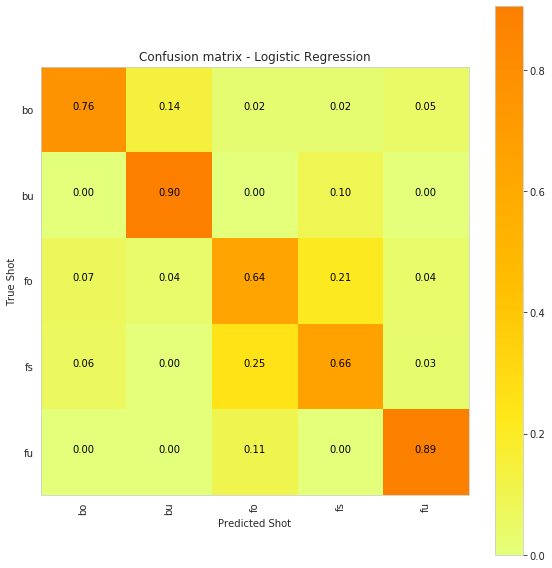

Classifiction Report for this model
              precision    recall  f1-score   support

          bo       0.89      0.76      0.82        42
          bu       0.73      0.90      0.81        21
          fo       0.62      0.64      0.63        28
          fs       0.70      0.66      0.68        32
          fu       0.81      0.89      0.85        19

    accuracy                           0.75       142
   macro avg       0.75      0.77      0.76       142
weighted avg       0.76      0.75      0.75       142



In [42]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Save the hyperparameters ie C value and loss-function type:
parameters = {'C':[0.01,0.1,1,10,20,30], 'penalty':['l2','l1']}
log_reg_clf = linear_model.LogisticRegression()
log_reg_model = GridSearchCV(log_reg_clf, param_grid=parameters, cv=3,verbose=1, n_jobs=8)

log_reg_model.fit(X_train,Y_train)
y_pred = log_reg_model.predict(X_test)
# y_prob = log_reg_model.predict_proba(X_test)
# print(y_prob)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)

# Accuracy of our stroke detectiony
print('Accuracy of strokes detection:   {}\n\n'.format(accuracy))
     
# confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name="Logistic Regression", 
                      shots=shot_labels, normalize=True)
plt.show()
    
# get classification report
print("Classifiction Report for this model")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### K- Nearest Neighbours

Accuracy of strokes detection:   0.6197183098591549




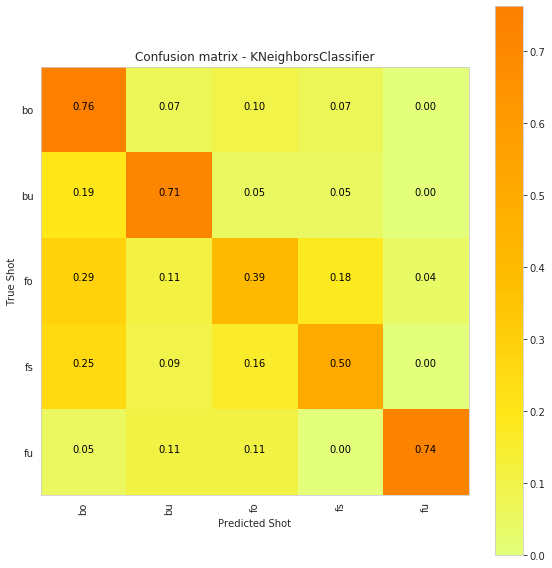

Classifiction Report for this model
              precision    recall  f1-score   support

          bo       0.60      0.76      0.67        42
          bu       0.58      0.71      0.64        21
          fo       0.48      0.39      0.43        28
          fs       0.64      0.50      0.56        32
          fu       0.93      0.74      0.82        19

    accuracy                           0.62       142
   macro avg       0.65      0.62      0.63       142
weighted avg       0.63      0.62      0.62       142



In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)

# Accuracy of our stroke detectiony
print('Accuracy of strokes detection:   {}\n\n'.format(accuracy))
     
# confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred)
    
# plot confusion matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='KNeighborsClassifier',
                      shots=shot_labels, normalize=True, )
plt.show()
    
# get classification report
print("Classifiction Report for this model")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Linear SVC

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    1.2s finished
/home/easy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/easy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of strokes detection:   0.6901408450704225




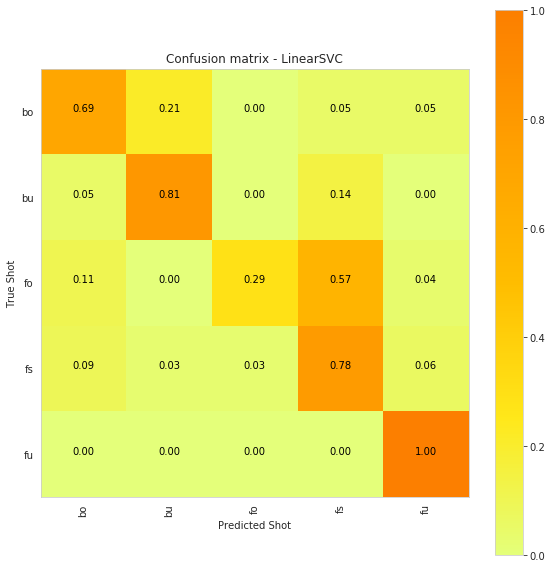

Classifiction Report for this model
              precision    recall  f1-score   support

          bo       0.81      0.69      0.74        42
          bu       0.63      0.81      0.71        21
          fo       0.89      0.29      0.43        28
          fs       0.54      0.78      0.64        32
          fu       0.79      1.00      0.88        19

    accuracy                           0.69       142
   macro avg       0.73      0.71      0.68       142
weighted avg       0.74      0.69      0.67       142



In [44]:
from sklearn.svm import LinearSVC
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc_reg_clf = LinearSVC(tol=0.00005)
lr_svc_reg_model = GridSearchCV(lr_svc_reg_clf, param_grid=parameters, n_jobs=8, verbose=1)

lr_svc_reg_model.fit(X_train,Y_train)
y_pred = lr_svc_reg_model.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# Accuracy of our stroke detectiony
print('Accuracy of strokes detection:   {}\n\n'.format(accuracy))
     
# confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred)
        
# plot confusion matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='LinearSVC',
                      shots=shot_labels, normalize=True)
plt.show()
    
# get classification report
print("Classifiction Report for this model")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### SVC with RBF kernel

Accuracy of strokes detection:   0.30985915492957744




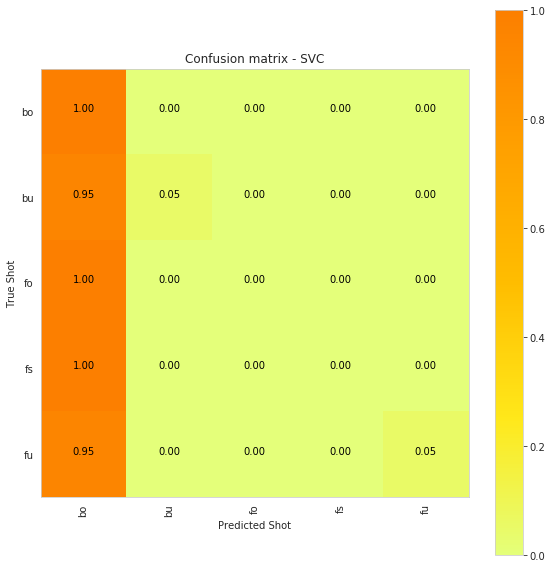

Classifiction Report for this model
              precision    recall  f1-score   support

          bo       0.30      1.00      0.46        42
          bu       1.00      0.05      0.09        21
          fo       0.00      0.00      0.00        28
          fs       0.00      0.00      0.00        32
          fu       1.00      0.05      0.10        19

    accuracy                           0.31       142
   macro avg       0.46      0.22      0.13       142
weighted avg       0.37      0.31      0.16       142



/home/easy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
from sklearn.svm import SVC
parameters = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm_clf = SVC(kernel='rbf')
rbf_svm_model = GridSearchCV(rbf_svm_clf,param_grid=parameters,n_jobs=8)

rbf_svm_model.fit(X_train,Y_train )
y_pred = rbf_svm_model.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# Accuracy of our stroke detectiony
print('Accuracy of strokes detection:   {}\n\n'.format(accuracy))
     
# confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='SVC', shots=shot_labels, normalize=True)
plt.show()
    
# get classification report
print("Classifiction Report for this model")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

/home/easy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy of strokes detection:   0.6690140845070423




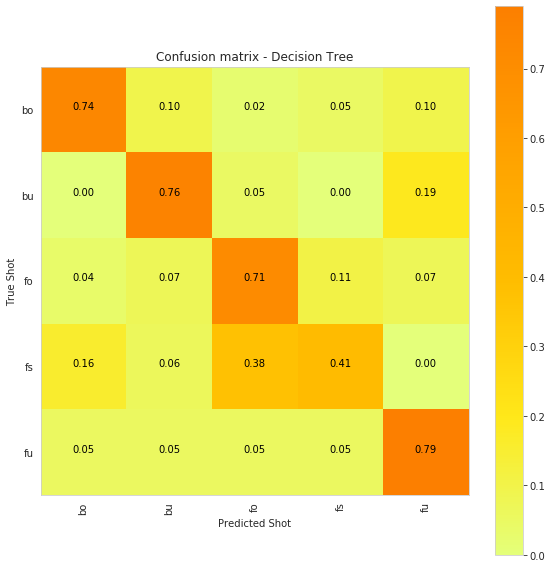

Classifiction Report for this model
              precision    recall  f1-score   support

          bo       0.82      0.74      0.78        42
          bu       0.64      0.76      0.70        21
          fo       0.57      0.71      0.63        28
          fs       0.68      0.41      0.51        32
          fu       0.60      0.79      0.68        19

    accuracy                           0.67       142
   macro avg       0.66      0.68      0.66       142
weighted avg       0.68      0.67      0.66       142



In [46]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(3,20,2)}
decision_trees_clf = DecisionTreeClassifier()
decision_trees = GridSearchCV(decision_trees_clf, param_grid=parameters, n_jobs=8)

decision_trees.fit(X_train,Y_train )
y_pred = decision_trees.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# Accuracy of our stroke detection
print('Accuracy of strokes detection:   {}\n\n'.format(accuracy))
     
# confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='Decision Tree',
                      shots=shot_labels, normalize=True)
plt.show()
    
# get classification report
print("Classifiction Report for this model")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Random Forest

Accuracy of strokes detection:   0.7816901408450704




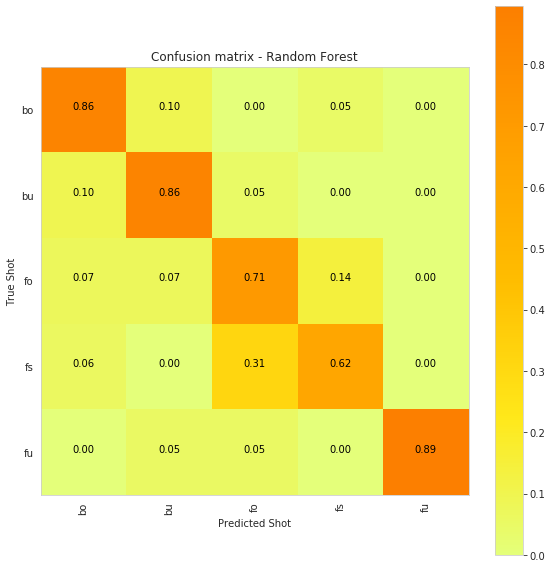

Classifiction Report for this model
              precision    recall  f1-score   support

          bo       0.86      0.86      0.86        42
          bu       0.72      0.86      0.78        21
          fo       0.62      0.71      0.67        28
          fs       0.77      0.62      0.69        32
          fu       1.00      0.89      0.94        19

    accuracy                           0.78       142
   macro avg       0.79      0.79      0.79       142
weighted avg       0.79      0.78      0.78       142



In [47]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': np.arange(10,120,20), 'max_depth':np.arange(3,15,2)}
rfclassifier_clf = RandomForestClassifier()
rfclassifier = GridSearchCV(rfclassifier_clf, param_grid=params, n_jobs=8)


rfclassifier.fit(X_train,Y_train )
y_pred = rfclassifier.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# Accuracy of our stroke detection
print('Accuracy of strokes detection:   {}\n\n'.format(accuracy))
     
# confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='Random Forest',
                      shots=shot_labels, normalize=True)
plt.show()

# get classification report
print("Classifiction Report for this model")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

### Gradient Boosting

/home/easy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy of strokes detection:   0.7183098591549296




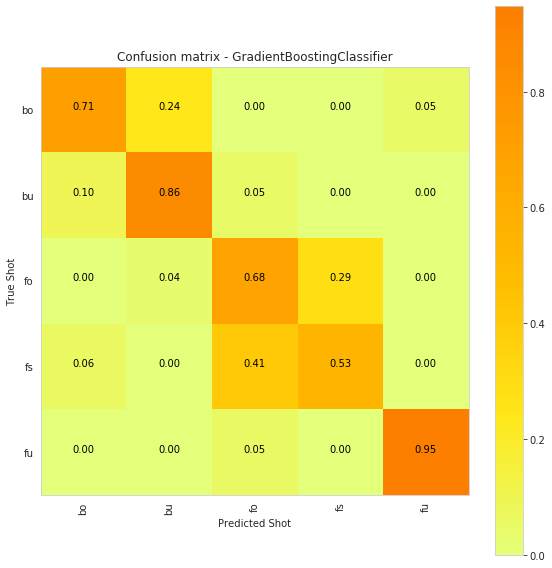

Classifiction Report for this model
              precision    recall  f1-score   support

          bo       0.88      0.71      0.79        42
          bu       0.62      0.86      0.72        21
          fo       0.56      0.68      0.61        28
          fs       0.68      0.53      0.60        32
          fu       0.90      0.95      0.92        19

    accuracy                           0.72       142
   macro avg       0.73      0.75      0.73       142
weighted avg       0.74      0.72      0.72       142



In [48]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {'max_depth': np.arange(1,30,4), \
             'n_estimators':np.arange(1,300,15)}
gbdt_clf = GradientBoostingClassifier()
gbdt_model = GridSearchCV(gbdt_clf, param_grid=param_grid, n_jobs=8)

gbdt_model.fit(X_train,Y_train )
y_pred = gbdt_model.predict(X_test)
accuracy = metrics.accuracy_score(y_true=Y_test,y_pred=y_pred)
# Accuracy of our stroke detectiony
print('Accuracy of strokes detection:   {}\n\n'.format(accuracy))
     
# confusion matrix
cm = metrics.confusion_matrix(Y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, model_name='GradientBoostingClassifier',
                      shots=shot_labels, normalize=True)
plt.show()
    
# get classification report
print("Classifiction Report for this model")
classification_report = metrics.classification_report(Y_test, y_pred)
print(classification_report)

## Deep Learning Models

Applying some deep learning models. The obvious choice will be to apply 1D CNN or RNNs for such a task. We tried only LSTMs.

In [49]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

Using TensorFlow backend.


In [50]:
# ShotNames are the class labels
# It is a 5 class classification
ShotNames = {
    'bo': [1, 0, 0, 0, 0],
    'bu': [0, 1, 0, 0, 0],
    'fo': [0, 0, 1, 0, 0],
    'fs': [0, 0, 0, 1, 0],
    'fu': [0, 0, 0, 0, 1],
}

In [52]:
X = []
y = []
for index, row in X_y.iterrows():
    df = data[row["PersonID"] + "_" + row["ShotName"]][row["StartFrame"]:row["EndFrame"]][cols]
    X.append(df.to_numpy())
    y.append(row["ShotName"])
X = np.array(X)
# One Hot Encoding
y = np.array([ShotNames[i] for i in y])

In [53]:
n_classes = len(ShotNames)
timesteps = len(X[0])    # Window size
input_dim = len(X[0][0]) # num of sensors = 6

In [54]:
# Initializing parameters
epochs = 100
batch_size = 16
n_hidden = 32

In [55]:
# Loading the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train , Y_test = train_test_split(X, y, test_size=0.1)

### LSTM

In [56]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 5,157
Trainable params: 5,157
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [58]:
# Training the model
model.fit(X_train, Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 637 samples, validate on 71 samples
Epoch 1/100
637/637 [==============================] - 3s 5ms/step - loss: 1.6241 - accuracy: 0.2308 - val_loss: 1.5853 - val_accuracy: 0.2676
Epoch 2/100
637/637 [==============================] - 1s 2ms/step - loss: 1.6098 - accuracy: 0.2465 - val_loss: 1.5887 - val_accuracy: 0.3099
Epoch 3/100
637/637 [==============================] - 1s 2ms/step - loss: 1.5880 - accuracy: 0.2622 - val_loss: 1.5809 - val_accuracy: 0.2958
Epoch 4/100
637/637 [==============================] - 1s 2ms/step - loss: 1.5921 - accuracy: 0.2684 - val_loss: 1.5780 - val_accuracy: 0.3099
Epoch 5/100
637/637 [==============================] - 1s 2ms/step - loss: 1.5727 - accuracy: 0.2700 - val_loss: 1.5787 - val_accuracy: 0.3099
Epoch 6/100
637/637 [==============================] - 1s 1ms/step - loss: 1.5603 - accuracy: 0.2826 - val_loss: 1.5757 - val_accuracy: 0.2817
Epoch 7/100
637/637 [==============================] - 2s 3ms/step - loss: 1.5319 - accuracy: 0.3

637/637 [==============================] - 1s 2ms/step - loss: 1.0564 - accuracy: 0.5965 - val_loss: 1.2604 - val_accuracy: 0.5070
Epoch 58/100
637/637 [==============================] - 1s 2ms/step - loss: 1.0014 - accuracy: 0.6013 - val_loss: 1.2146 - val_accuracy: 0.4648
Epoch 59/100
637/637 [==============================] - 1s 2ms/step - loss: 0.9893 - accuracy: 0.6154 - val_loss: 1.1943 - val_accuracy: 0.5070
Epoch 60/100
637/637 [==============================] - 1s 2ms/step - loss: 0.9850 - accuracy: 0.6358 - val_loss: 1.1446 - val_accuracy: 0.5070
Epoch 61/100
637/637 [==============================] - 2s 3ms/step - loss: 0.9695 - accuracy: 0.6075 - val_loss: 1.1165 - val_accuracy: 0.5493
Epoch 62/100
637/637 [==============================] - 1s 2ms/step - loss: 0.9453 - accuracy: 0.6641 - val_loss: 1.1455 - val_accuracy: 0.4789
Epoch 63/100
637/637 [==============================] - 1s 2ms/step - loss: 0.9221 - accuracy: 0.6546 - val_loss: 1.1140 - val_accuracy: 0.5493
Epoch

Data being pretty less for deep learning models, so we didn't try deeper networks.

## Final Notes

This project taught us a lot about doing a machine learning project. Specially the challenges that arise in data collection and it's preprocessing. Overall this is just a small project we did for learning. It can be extended in several ways, first of all by getting more data, so that models like LSTM can be employed. For classical models, we can add more features, do PCA, etc.

Overall a great learning experience. Please feel free to play with it and suggestions are always welcome.